## This script plots the frequencies of single words and word combinations in text. <br> Use custom colours, change opacity to reflect word frequency and set the length of the word combinations yourself. <br> <br> Viktoria, April 2021

In [ ]:
import os
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import docx2txt
import re
import pdfplumber
import textract
import ocrmypdf
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import CountVectorizer

#custom functions
from read_pdf import read_pdf 
from clean_text import *

pd.options.display.max_rows = 8000
pd.options.mode.chained_assignment = None

In [23]:
base = os.getcwd()
documents = os.path.join(base, 'Documents')
results = os.path.join(base, 'Plots')

In [3]:
#Go to the base directory to access the requirements file

os.chdir(base)

In [4]:
#pip install -r requirements.txt

In [5]:
#pip install git+https://github.com/jbarlow83/OCRmyPDF.git

In [6]:
#Get the texts from the different classes 

os.chdir(documents)

Dir1 = os.path.join(base, 'Documents/Class_1')
Dir2 = os.path.join(base, 'Documents/Class_2')
Dir3 = os.path.join(base, 'Documents/Class_3')

Docs1 = [c for c in os.listdir(Dir1)]
Docs2 = [c for c in os.listdir(Dir2)]
Docs3 = [c for c in os.listdir(Dir3)]


print('Class1: ', len(Docs1), '\nClass2: ', len(Docs2), '\nClass3: ', len(Docs3))

Class1:  10 
Class2:  11 
Class3:  12


In [7]:
# Articificially balance the classes: take the same number at random
# Or : tweak the ratio according to the ratio expected in the population

D1 = dict.fromkeys(Docs1, Dir1)
#D1 = random.choices(list(D1.items()), k = 10)

D2 = dict.fromkeys(Docs2, Dir2)
#D2 = random.choices(list(D2.items()), k = 10)

D3 = dict.fromkeys(Docs3, Dir3)
#D3 = random.choices(list(D3.items()), k = 10)

#create a dataset where the keys are the document names, and the values are the class
data = {**D1, **D2, **D3} 

In [8]:
#loop through them all at once. 200 docs takes ~10mins

df = pd.DataFrame(columns=['Document', 'Text', 'Dir', 'Cleaned_Text'])

df['Document'] = data.keys()
df['Dir'] = data.values()   

start = time.time()

df['Text'] = [m for m in map(read_pdf, tqdm(df.Document), df.Dir)]
      
end = time.time()
print(end - start)

100%|██████████| 33/33 [06:48<00:00, 12.37s/it]

408.2707448005676


In [9]:
#Delete the silly characters from the beginning of the title until the first capital letter

def replace_silly(string):

    string = re.sub(r'^[^A-Z.-]+\s*', '', string)
    
    return string

In [10]:
df['Document']=df['Document'].apply(replace_silly)

## Text cleaning and lemmatization

In [12]:
#A set of words we want to screen out as corpus-specific stop words, i.e. 'article', 'paragraph', etc in legal texts
os.chdir(base)

result = docx2txt.process("useless_words.docx")
useless = re.findall(r'\w+', result)
useless = lemmatize(useless)
useless = [u.lower() for u in useless]

In [13]:
# All non-English words will be disposed of. Keep important non-English words that are on this list.
os.chdir(base)

result = docx2txt.process("informative_words.docx")
informative = re.findall(r'\w+', result)
informative = [i.lower() for i in informative]

In [14]:
#Call clean_text.py to lemmatize the text and filter out standard stop-words and corpus-specific stop-words.

df['Cleaned_Text'] = df['Text'].apply(clean_text, args=(useless, informative))


In [21]:
#Remove any Nones 
df = df.dropna()

## Plot the most frequent words and collocations in each class


### Class 1 single words

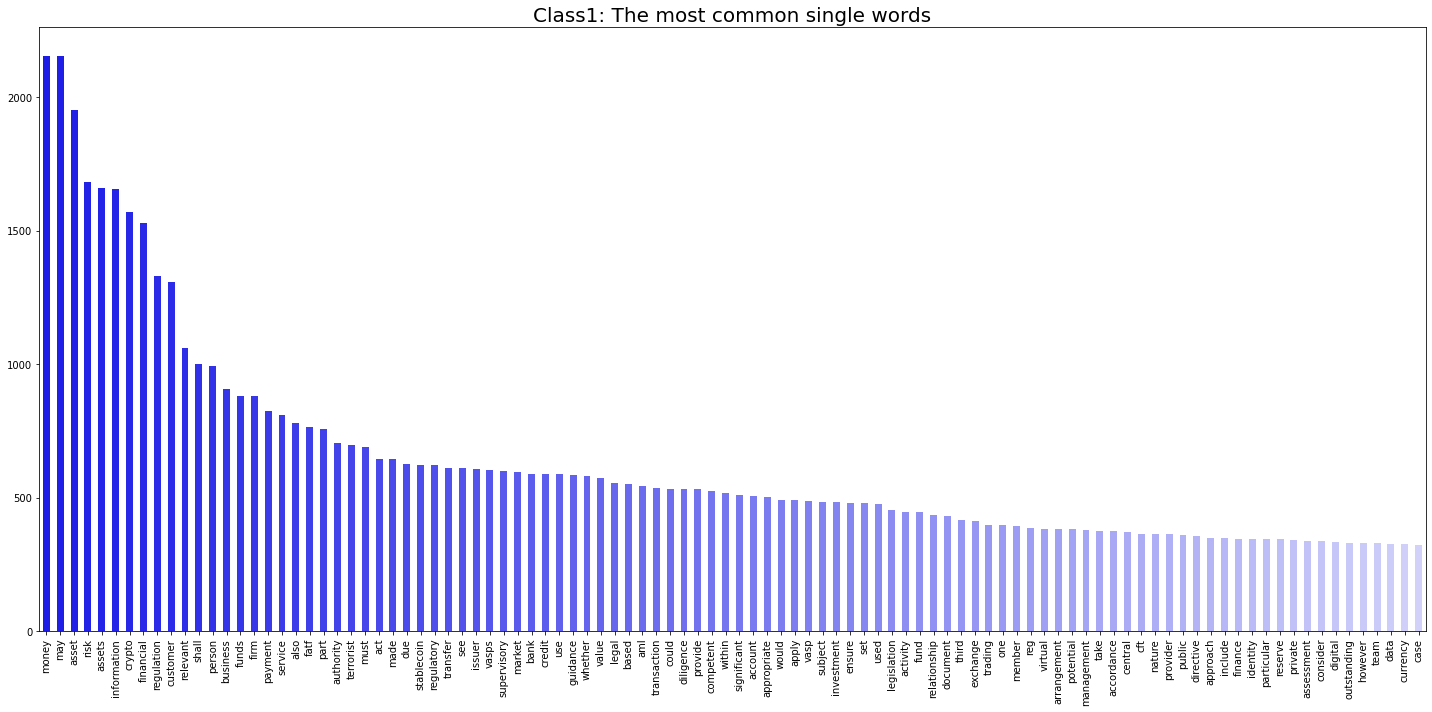

In [31]:
#Plot the n most common words

n = 100 #change the number of words here

os.chdir(results)

class1 = df[df.Dir==Dir1]

texts = []
texts.extend([item for item in class1.Cleaned_Text])
flat_list = [item for sublist in texts for item in sublist]

words = pd.Series(flat_list).value_counts()
words = words.astype('float')
words = words[0:n]

plt.figure(figsize=(20,10))

#reduce opacity as the item becomes less frequent
alpha = [x for x in np.arange(0.2, 1, 0.8/n)]
alpha = alpha[::-1]
colours = [(0.1, 0.1, 0.9, a) for a in alpha]

words.plot.bar(width=0.5, color=colours)
plt.title('Class1: The most common single words', fontsize = 20)
plt.tight_layout() #to make sure the text is legible 
plt.savefig('class1_words.png')

### Class 1 collocations

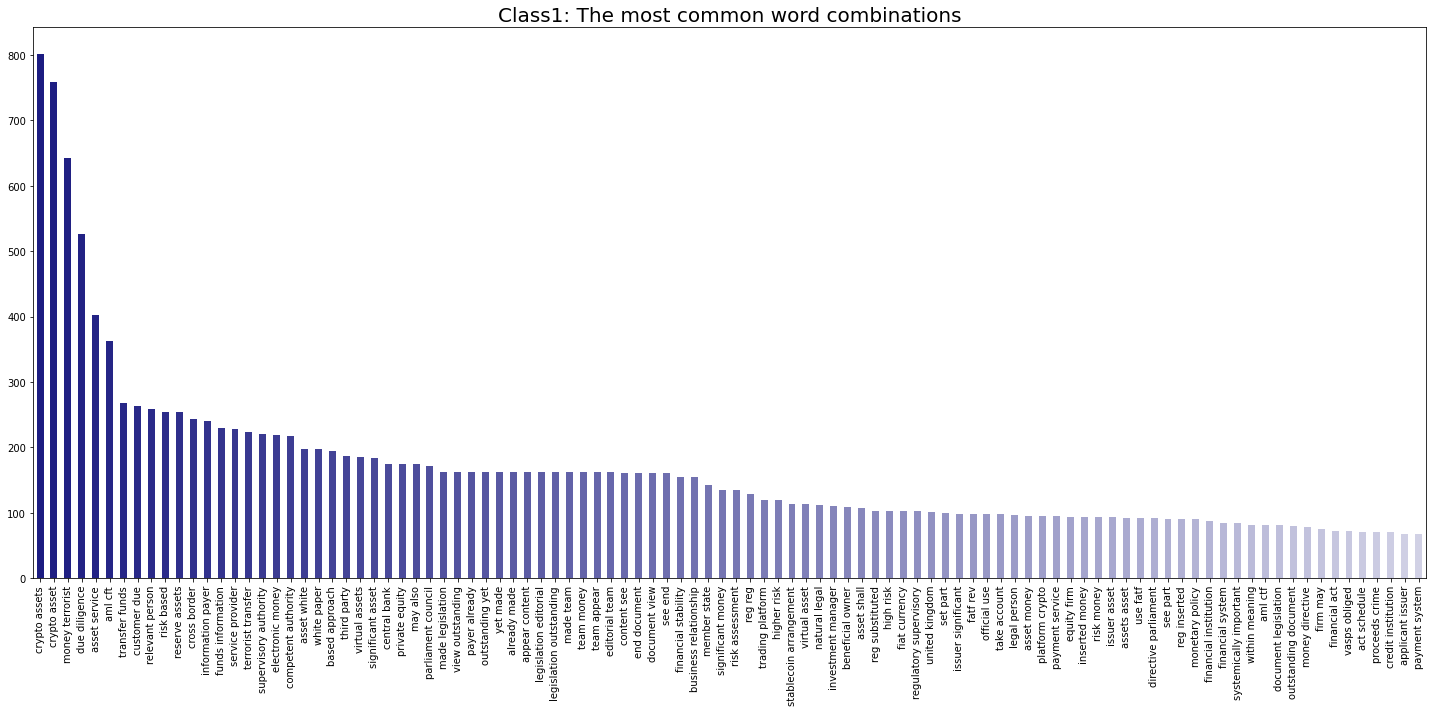

In [32]:
#Plot the most common word combinations

n = 100 #change the number of words here
lencol = 2 #change the length of the word combinations (2-words, 3-words, etc)

os.chdir(results)

class1 = df[df.Dir==Dir1]

texts = []
texts.extend(' '.join(d for d in class1['Cleaned_Text'][index]) for index, row in class1.iterrows())

cv = CountVectorizer(ngram_range=(1,lencol))

cv.fit(texts)

texts_transformed = cv.transform(texts)
texts_transformed

n_data = pd.DataFrame(texts_transformed.toarray(),
                 columns=cv.get_feature_names())

counts = pd.DataFrame([n_data.sum(axis=0)])
counts = counts.drop([col for col in counts.columns if len(col.split())<lencol] , axis='columns')

#50 most frequent collocations
collocations = counts.transpose() #columns to rows
collocations = collocations.squeeze() #convert to series
collocations = collocations.astype('float')
collocations = collocations.sort_values(ascending=False)
collocations = collocations[0:n]

#reduce opacity as the item becomes less frequent
alpha = [x for x in np.arange(0.2, 1, 0.8/100)]
alpha = alpha[::-1]
colours = [(0.1, 0.1, 0.5, a) for a in alpha]

plt.figure(figsize=(20,10))
collocations.plot.bar(width=0.5, color=colours)
plt.title('Class1: The most common word combinations', fontsize = 20)
plt.tight_layout() #to make sure the text is legible 
plt.savefig('class1_collocations.png')

### Class 2 single words

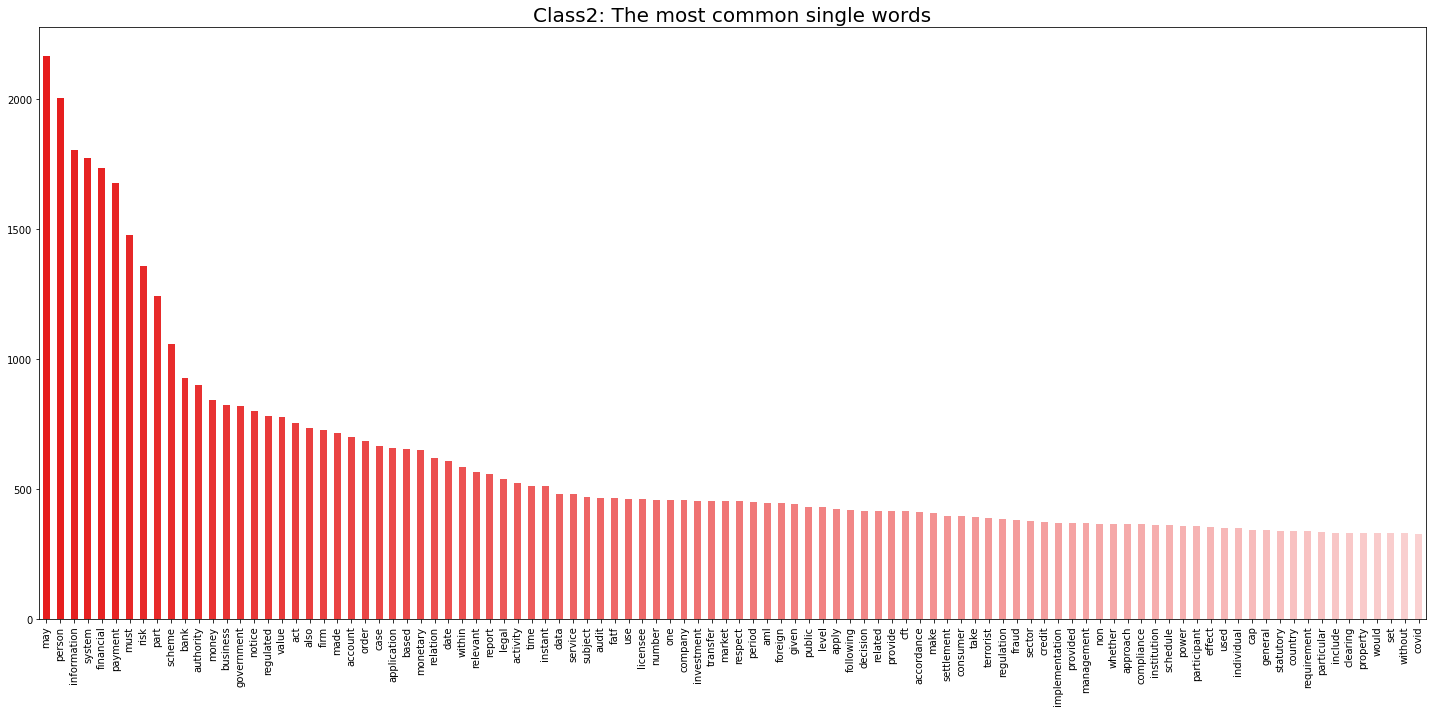

In [33]:
#Plot the n most common words

n = 100 #change the number of words here

os.chdir(results)

class2 = df[df.Dir==Dir2]

texts = []
texts.extend([item for item in class2.Cleaned_Text])
flat_list = [item for sublist in texts for item in sublist]

words = pd.Series(flat_list).value_counts()
words = words.astype('float')
words = words[0:n]

plt.figure(figsize=(20,10))

#reduce opacity as the item becomes less frequent
alpha = [x for x in np.arange(0.2, 1, 0.8/n)]
alpha = alpha[::-1]
colours = [(0.9, 0.1, 0.1, a) for a in alpha]

words.plot.bar(width=0.5, color=colours)
plt.title('Class2: The most common single words', fontsize = 20)
plt.tight_layout() #to make sure the text is legible 
plt.savefig('class2_words.png')

### Class 2 collocations

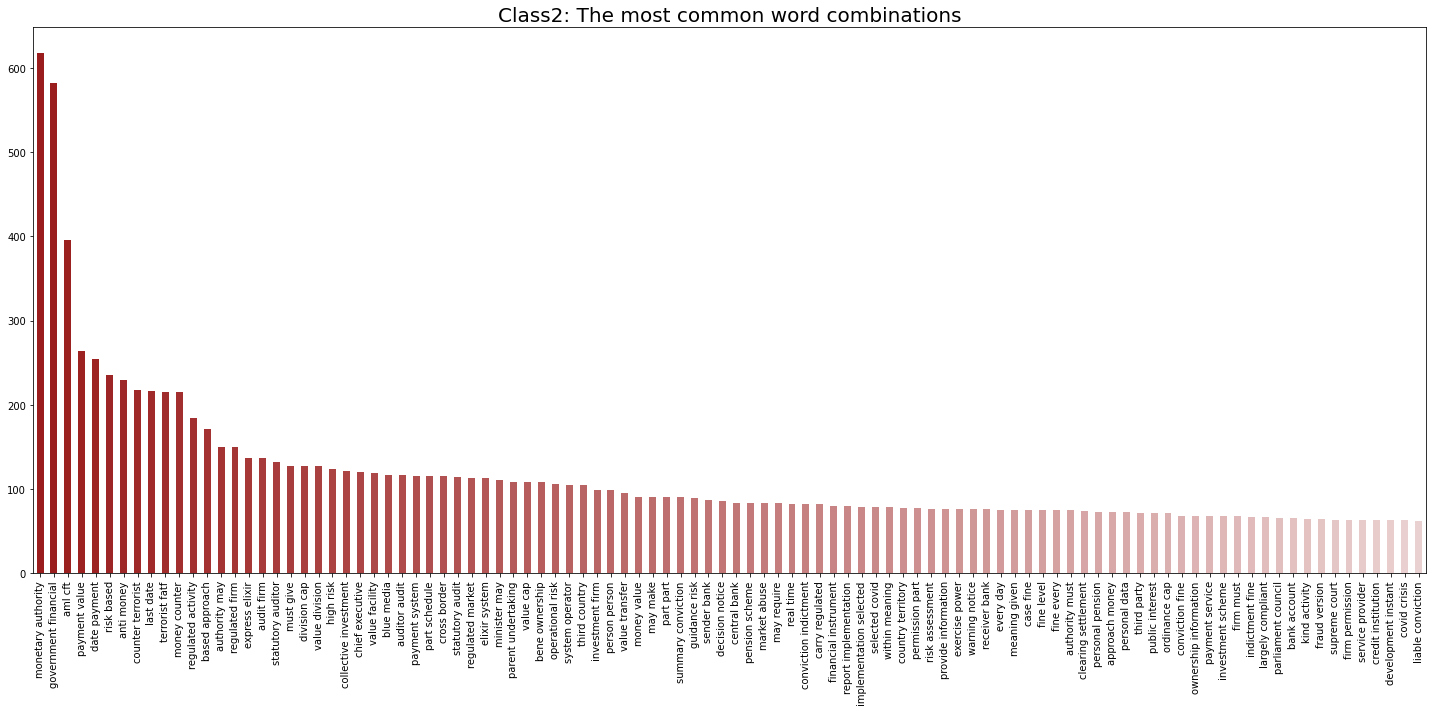

In [35]:
#Plot the most common word combinations

n = 100 #change the number of words here
lencol = 2 #change the length of the word combinations (2-words, 3-words, etc)

os.chdir(results)

class2 = df[df.Dir==Dir2]

texts = []
texts.extend(' '.join(d for d in class2['Cleaned_Text'][index]) for index, row in class2.iterrows())

cv = CountVectorizer(ngram_range=(1,lencol))

cv.fit(texts)

texts_transformed = cv.transform(texts)
texts_transformed

n_data = pd.DataFrame(texts_transformed.toarray(),
                 columns=cv.get_feature_names())

counts = pd.DataFrame([n_data.sum(axis=0)])
counts = counts.drop([col for col in counts.columns if len(col.split())<lencol] , axis='columns')

#50 most frequent collocations
collocations = counts.transpose() #columns to rows
collocations = collocations.squeeze() #convert to series
collocations = collocations.astype('float')
collocations = collocations.sort_values(ascending=False)
collocations = collocations[0:n]

#reduce opacity as the item becomes less frequent
alpha = [x for x in np.arange(0.2, 1, 0.8/100)]
alpha = alpha[::-1]
colours = [(0.6, 0.1, 0.1, a) for a in alpha]

plt.figure(figsize=(20,10))
collocations.plot.bar(width=0.5, color=colours)
plt.title('Class2: The most common word combinations', fontsize = 20)
plt.tight_layout() #to make sure the text is legible 
plt.savefig('class2_collocations.png')

### Class 3 single words

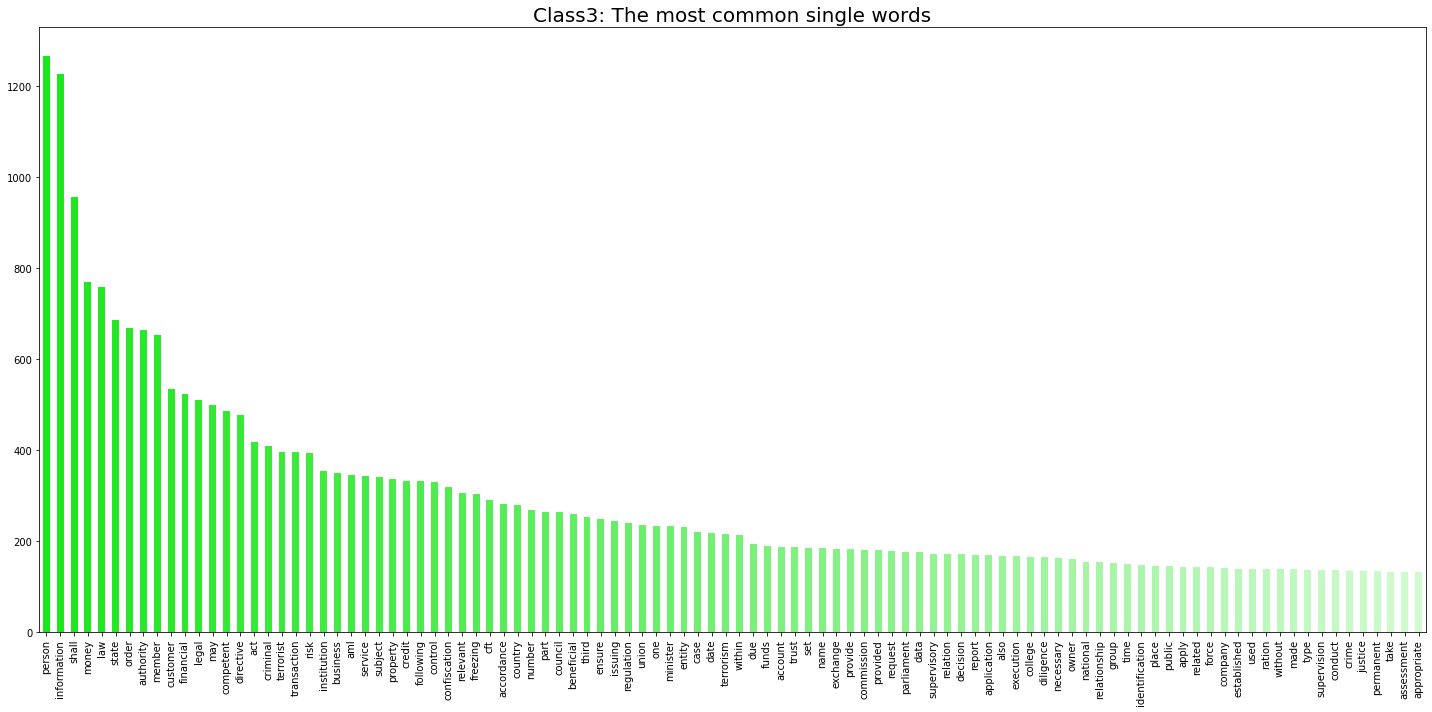

In [36]:
#Plot the n most common words

n = 100 #change the number of words here

os.chdir(results)

class3 = df[df.Dir==Dir3]

texts = []
texts.extend([item for item in class3.Cleaned_Text])
flat_list = [item for sublist in texts for item in sublist]

words = pd.Series(flat_list).value_counts()
words = words.astype('float')
words = words[0:n]

plt.figure(figsize=(20,10))

#reduce opacity as the item becomes less frequent
alpha = [x for x in np.arange(0.2, 1, 0.8/n)]
alpha = alpha[::-1]
colours = [(0.1, 0.9, 0.1, a) for a in alpha]

words.plot.bar(width=0.5, color=colours)
plt.title('Class3: The most common single words', fontsize = 20)
plt.tight_layout() #to make sure the text is legible 
plt.savefig('class3_words.png')

### Class 3 collocations

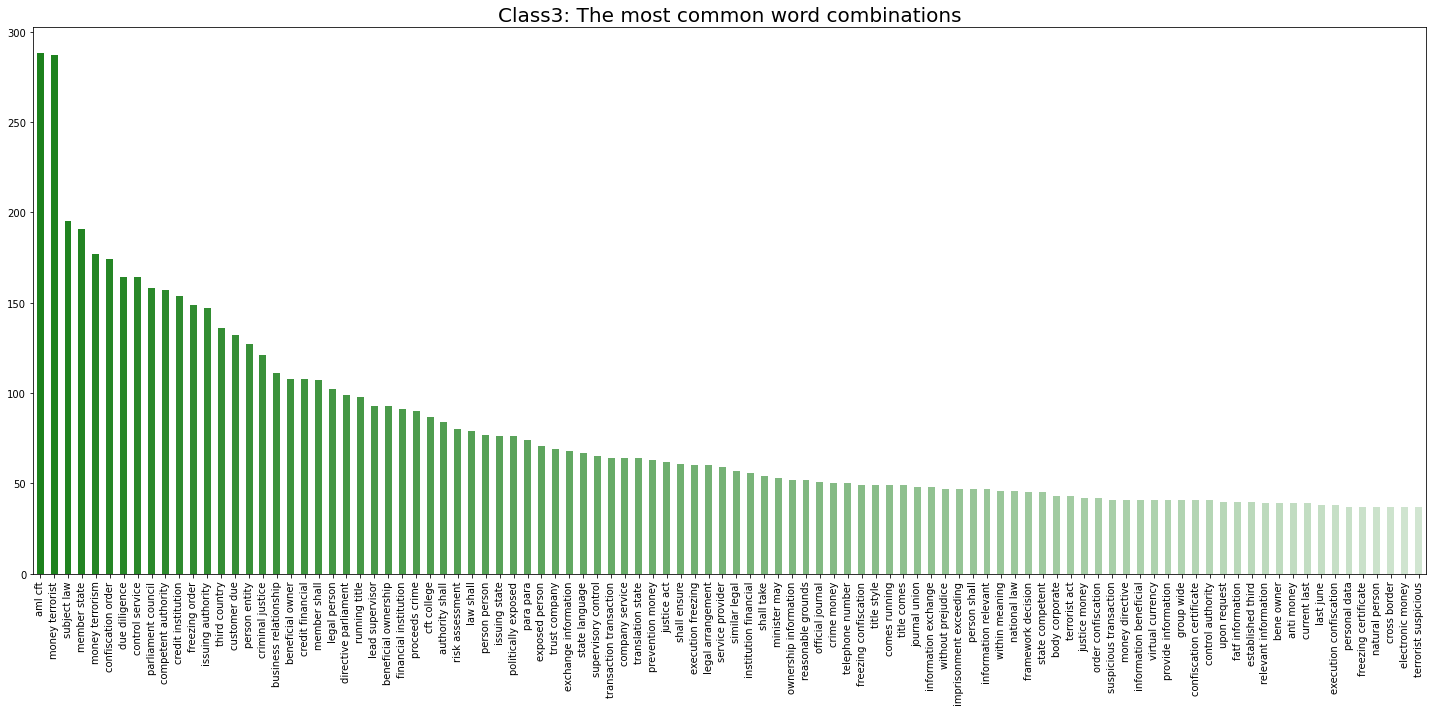

In [38]:
#Plot the most common word combinations

n = 100 #change the number of words here
lencol = 2 #change the length of the word combinations (2-words, 3-words, etc)

os.chdir(results)

class3 = df[df.Dir==Dir3]

texts = []
texts.extend(' '.join(d for d in class3['Cleaned_Text'][index]) for index, row in class3.iterrows())

cv = CountVectorizer(ngram_range=(1,lencol))

cv.fit(texts)

texts_transformed = cv.transform(texts)
texts_transformed

n_data = pd.DataFrame(texts_transformed.toarray(),
                 columns=cv.get_feature_names())

counts = pd.DataFrame([n_data.sum(axis=0)])
counts = counts.drop([col for col in counts.columns if len(col.split())<lencol] , axis='columns')

#50 most frequent collocations
collocations = counts.transpose() #columns to rows
collocations = collocations.squeeze() #convert to series
collocations = collocations.astype('float')
collocations = collocations.sort_values(ascending=False)
collocations = collocations[0:n]

#reduce opacity as the item becomes less frequent
alpha = [x for x in np.arange(0.2, 1, 0.8/100)]
alpha = alpha[::-1]
colours = [(0.1, 0.5, 0.1, a) for a in alpha]

plt.figure(figsize=(20,10))
collocations.plot.bar(width=0.5, color=colours)
plt.title('Class3: The most common word combinations', fontsize = 20)
plt.tight_layout() #to make sure the text is legible 
plt.savefig('class3_collocations.png')